In [36]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [37]:
plt.rcParams["figure.figsize"] = (25,15)
plt.rcParams.update({'font.size': 22})

In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [39]:
path="/Users/daniel.bustillo/Documents/thesis/2016"

os.chdir(path)

In [40]:
# all_files = glob.glob(os.path.join(path , "*2016.csv"))


# # create empty list
# dataframes_list = []
  
# # append datasets into teh list
# for i in range(len(all_files)):
#     temp_df = pd.read_csv(all_files[i], parse_dates=True, index_col=0, infer_datetime_format=True, header=None)
#     dataframes_list.append(temp_df)
# dataframes_list = [df.resample("1H").mean() for df in dataframes_list]

# apts= pd.concat(dataframes_list, axis=1)
# apts.columns = np.arange(len(apts.columns))
# apts= apts.add_prefix("apt_")
# #apts.to_csv("apts.csv")


In [41]:
apts = pd.read_csv("apts.csv", infer_datetime_format=True, index_col=0, parse_dates=True)

# EDA and plots

In [13]:
apts1 = apts.copy()
apts['hour'] = apts.index.hour
apts['weekday'] = apts.index.weekday
avg= apts.groupby(['hour','weekday']).mean()['apt_20']
avg = avg.reset_index()
avg_pivot= avg.pivot("hour","weekday","apt_20")
avg_pivot.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

Text(0.5, 1.0, 'Average weekly electricity consumption in Apt 20 (in kWh)')

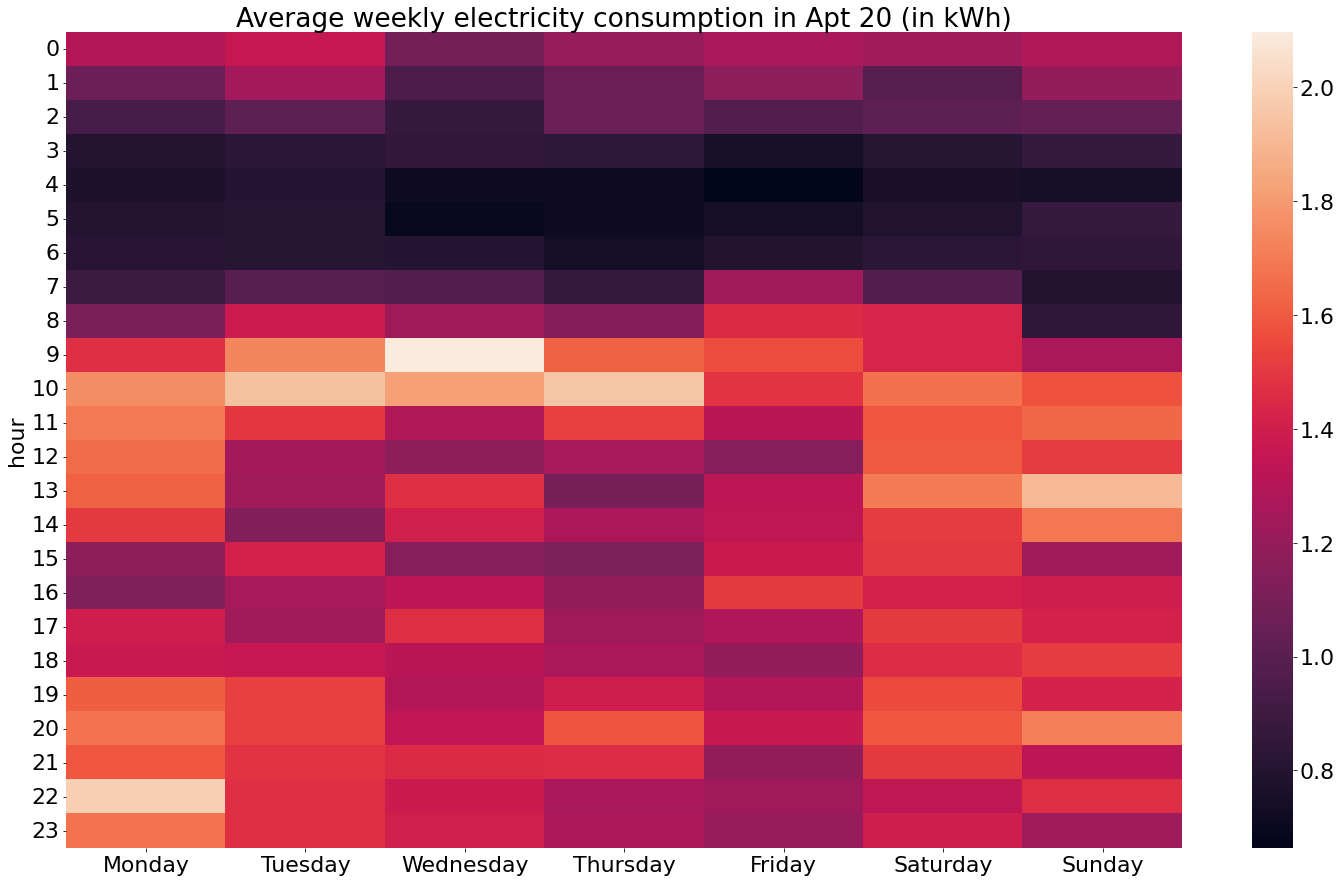

In [14]:
g=sns.heatmap(avg_pivot)
locs, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title("Average weekly electricity consumption in Apt 20 (in kWh)")

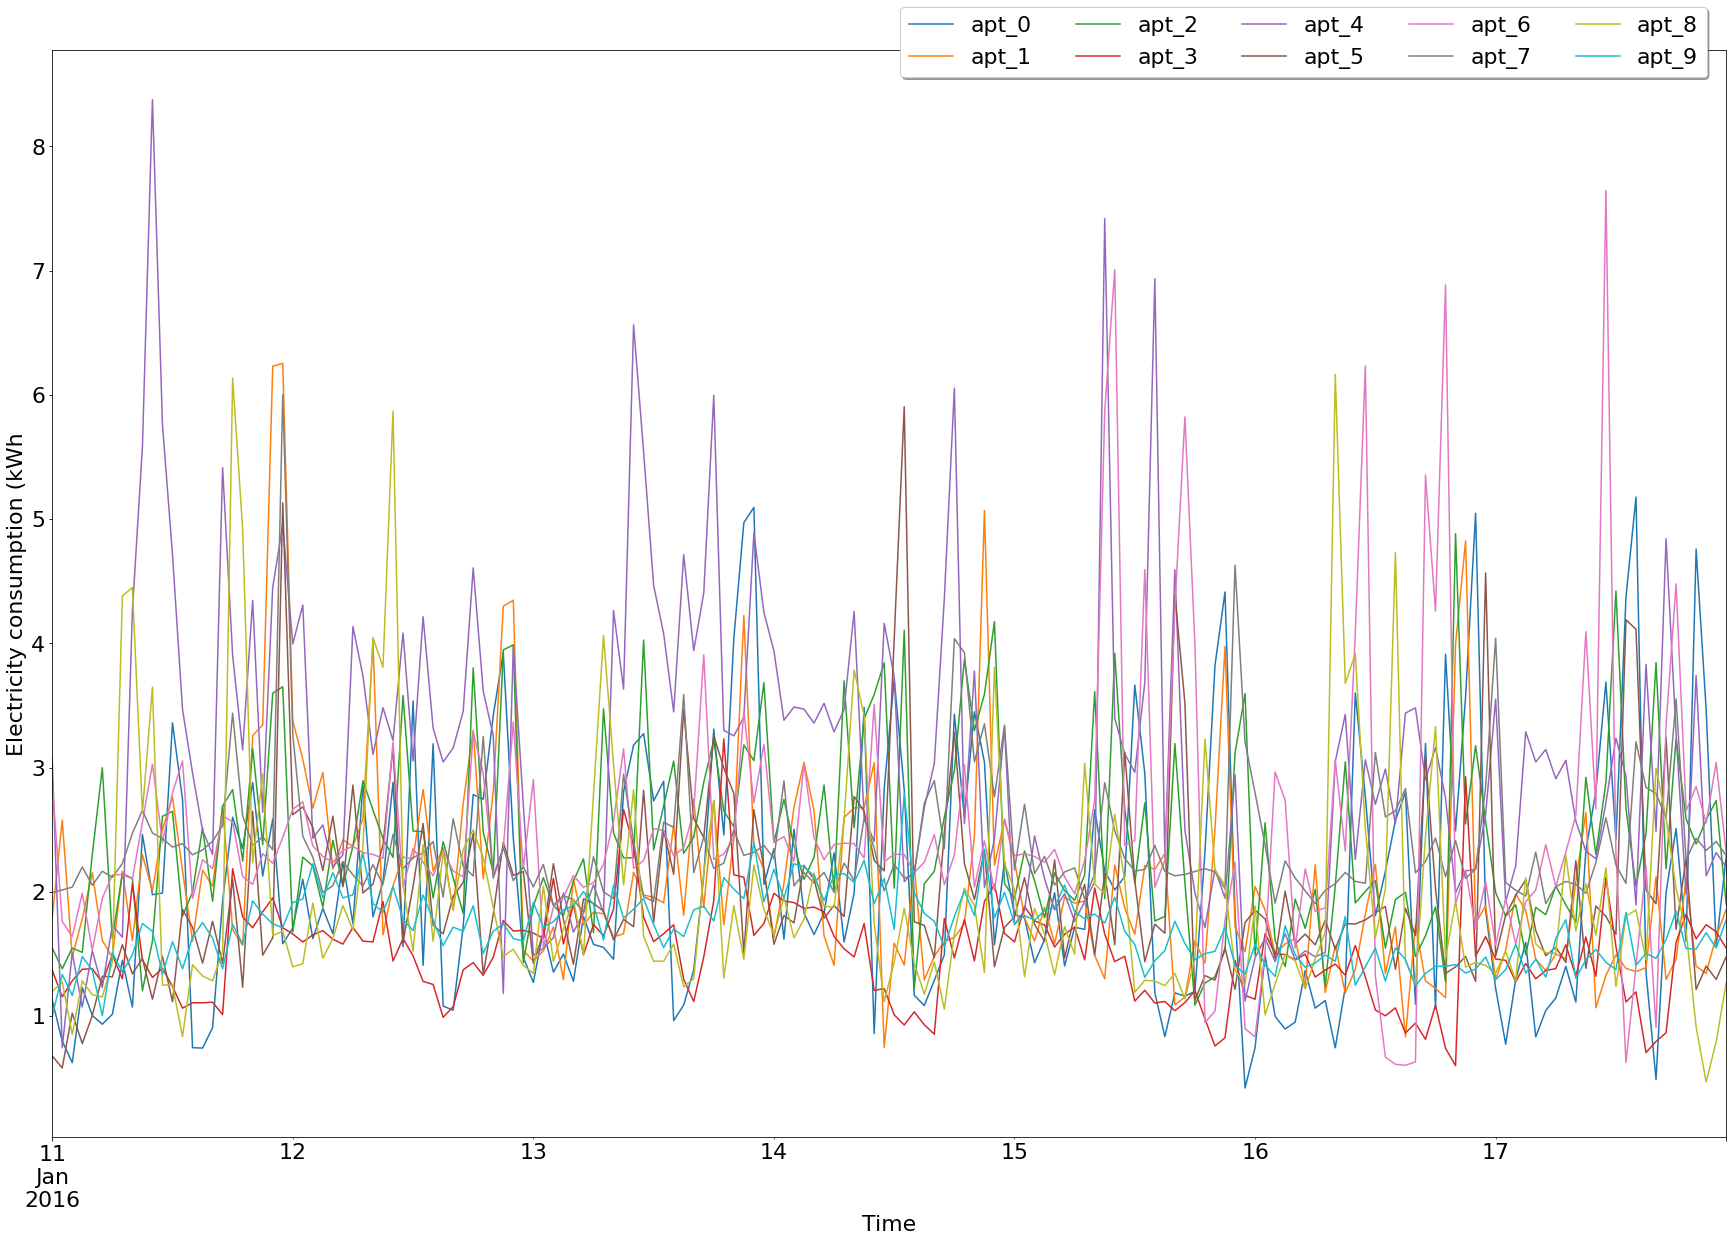

In [42]:
apts.iloc[240:408,:10].plot(figsize=(30,20), xlabel="Time", ylabel= "Electricity consumption (kWh")
plt.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)
plt.show()


# Single LSTM

In [57]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [58]:
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error
def mape(y_true, y_score):
    error = mean_absolute_percentage_error(y_true, y_score)
    return error

In [59]:
def run_model(home: pd.Series, train_size=0.8, timesteps= 1, epochs=50, batch_size= 64, neurons=128, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

    #Define the model
    model = Sequential()
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    




    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"simple_lstm_{home.name}"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test[f'simple_lstm_{home.name}'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    if plot== True:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'simple_lstm_{home.name}'])
        plt.show()
    else:
        pass

    rmse_test[f'single_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    rmse_train[f'single_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

    mape_test[f'single_{home.name}'] = mape(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    mape_train[f'single_{home.name}'] = mape(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'single_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'single_{home.name}']}")




    


    

In [60]:
def run_conv_model(home: pd.Series, train_size, timesteps= 1, n_features=1, epochs=50, batch_size= 64, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

   

    conv = Sequential()
    conv.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
    conv.add(MaxPooling1D(pool_size=1))
    conv.add(Flatten())
    conv.add(Dense(50, activation='relu'))
    conv.add(Dense(1))
    conv.compile(optimizer='adam', loss='mse')

    #Fit the data
    history= conv.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    
    # pred_train ={}
    # pred_test = {}

    # rmse_train ={}
    # rmse_test = {}

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"convlstm_{home.name}"] = scaler.inverse_transform(
                                conv.predict(X_train,verbose=0)).flatten()

    pred_test[f'convlstm_{home.name}'] = scaler.inverse_transform(conv.predict(X_test)).flatten()

    if plot==True:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'convlstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'conv_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    rmse_train[f'conv_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])

    mape_test[f'conv_{home.name}'] = mape(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    mape_train[f'conv_{home.name}'] = mape(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])


  
    print(f"The RMSE in the train set is: {rmse_train[f'conv_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'conv_{home.name}']}")



    


    

In [61]:

pred_train={}
pred_test= {}

rmse_train={}
rmse_test={}

mape_train = {}
mape_test={}

## Hyperparameter Tuning

In [78]:
#install the package
import keras_tuner as kt
import keras.optimizers

In [79]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Choice('units',[24,64,128,256,512])))
  model.add(Dense(1, activation='relu'))
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-1, 1e-2, 1e-3])), metrics=['mean_squared_error'])

  
  return model

In [80]:
tuner = kt.RandomSearch(
    build_model,
    objective= 'val_mean_squared_error',
    max_trials=30)

In [85]:
timesteps=1

In [86]:
home = apts['apt_0']
# train, test split
# split into train and test sets
values = home.values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.9, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [87]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 13 Complete [00h 00m 11s]
val_mean_squared_error: 0.0008049007155932486

Best val_mean_squared_error So Far: 0.0007712855003774166
Total elapsed time: 00h 03m 20s
INFO:tensorflow:Oracle triggered exit


In [95]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.001
Score: 0.0007712855003774166
Trial summary
Hyperparameters:
units: 24
learning_rate: 0.001
Score: 0.0007757717976346612
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.001
Score: 0.0007857651798985898
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.001
Score: 0.0008049007155932486
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.1
Score: 0.0008378610946238041
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.012532583437860012
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.01
Score: 0.012532583437860012
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.001
Score: 0.012532583437860012
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.1
Score: 0.012532583437860012
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.1
Score: 0.012532583437860012


## Multivariate LSTM

In [101]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [102]:
values= apts.values
values = values.astype('float32')

In [103]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [104]:
apartments ={}


In [115]:

for j in range(40,80):
    apartments[reframed.iloc[:,j].name] = reframed.iloc[:, np.r_[0:39,j]]


In [106]:
def train_multi_model(df, train_size = 0.9, neurons = 256, epochs=50, batch_size=64):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean square'''
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=["mean_squared_error", "mean_absolute_error"])


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)


    #Predict on both sets
    yhat_test= model.predict(X_test)
    yhat_train = model.predict(X_train)

    #Reshape them to fit the right format to inverse_transform
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))

    inv_yhat_test= np.concatenate((X_test, yhat_test), axis=1)
    inv_yhat_train=np.concatenate((X_train, yhat_train), axis=1)

    inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)

    multi_test_pred= inv_yhat_test[:,-1]
    multi_train_pred = inv_yhat_train[:,-1]

    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    y_train = y_train.reshape(len(y_train),1)

    inv_y_test= np.concatenate((X_test, y_test), axis=1)
    inv_y_train= np.concatenate((X_train, y_train), axis=1)

    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_train = scaler.inverse_transform(inv_y_train)

    multi_test_true= inv_y_test[:,-1]
    multi_train_true = inv_y_train[:,-1]


    multi_rmse_test= rmse(inv_y_test, inv_yhat_test)
    multi_rmse_train = rmse(inv_y_train, inv_yhat_train)

    multi_mape_test= mape(inv_y_test, inv_yhat_test)
    multi_mape_train = mape(inv_y_train, inv_yhat_train)

    #multi_test = pd.DataFrame(multi_test)


    #multi_test.plot()

    return multi_train_pred, multi_test_pred,multi_train_true, multi_test_true,multi_rmse_train,multi_rmse_test, multi_mape_train, multi_mape_test

    
    

    

    
    

# Federated Model

In [62]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [63]:
class SimpleLSTM:
    @staticmethod
    def build(neurons, timesteps =1, n_features=1):
        model = Sequential()
        model.add(LSTM(neurons, input_shape =(timesteps,n_features)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
        
        
        return model

In [64]:
def weight_scalling_factor(clients_trn_data, client_name):
    #client_names = list(homes.columns())
    #get the bs
    #bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([len(clients_trn_data[client_name].dropna()) for client_name in client_names])
    # get the total number of data points held by a client
    local_count = len(clients_trn_data[client_name].dropna())
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error
    
def mape(y_true,y_score):
    error = mean_absolute_percentage_error(y_true, y_score)
    return error
    
def test_model(X_test, Y_test,  model, comm_round, home):
    preds = model.predict(X_test)
    loss = rmse(Y_test, preds)
    scaled_preds= scaler.inverse_transform(preds)
    scaled_loss = rmse(scaler.inverse_transform(Y_test), scaled_preds)
    print('comm_round: {} |loss_in_{}: {} | scaled_loss_in_{}: {}'.format(comm_round,home,loss, home, scaled_loss))
    return loss, scaled_loss, preds, scaled_preds

In [72]:
def prepare_task(home: pd.Series, train_size= 0.9, timesteps= 1, epochs=50, batch_size= 64):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    #print(X_train.shape)

    return X_train, y_train, X_test, y_test, scaler


In [73]:
comms_round = 50
    
#create optimizer
lr = 0.01 
loss='mean_squared_error'
metrics = ['mse']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 



In [74]:
client_names = apts.columns

In [75]:
#initialize global model
smlp_global = SimpleLSTM()
global_model = smlp_global.build(512, 1, 1) #Number of hidden units defined by hyperparameter tuning
        


In [76]:

# pred_train={}
# pred_test= {}

# rmse_train={}
# rmse_test={}

# mape_train ={}
# mape_test ={}

In [78]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for house in apts:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(512)
        local_model.compile(loss=loss, 
                        optimizer=optimizer, #Trying out adam
                        metrics=metrics)
        
        
    #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        #scaler = MinMaxScaler(feature_range=(0, 1))
        X_train, y_train, X_test, y_test, scaler= prepare_task(apts[house])


        local_model.fit(X_train, y_train, epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(apts, house)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        local_loss = test_model(X_test, y_test, global_model, comm_round, house)


        pred_train[f"true_{house}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
        pred_test[f"true_{house}"]  = scaler.inverse_transform(y_test).flatten() 

        pred_train[f"fed_{house}"] = scaler.inverse_transform(
                                    local_model.predict(X_train)).flatten()

        pred_test[f"fed_{house}"] = scaler.inverse_transform(local_model.predict(X_test)).flatten()

        rmse_test[f'fed_{house}'] = rmse(pred_test[f'true_{house}'], pred_test[f'fed_{house}'])
        rmse_train[f'fed_{house}'] = rmse(pred_train[f'true_{house}'], pred_train[f'fed_{house}'])

        mape_test[f'fed_{house}'] = mape(pred_test[f'true_{house}'], pred_test[f'fed_{house}'])
        mape_train[f'fed_{house}'] = mape(pred_train[f'true_{house}'], pred_train[f'fed_{house}'])

        # #plot the predictions
        # plt.plot(pred_test[f'true_{home}'])
        # plt.plot(pred_test[f'simple_lstm_{home}'])
        # plt.show()

        K.clear_session()
    
            
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
  

comm_round: 0 |loss_in_apt_0: 0.11313001661259507 | scaled_loss_in_apt_0: 0.8637305814668776
comm_round: 0 |loss_in_apt_1: 0.25981103320711246 | scaled_loss_in_apt_1: 1.7650980630226603
comm_round: 0 |loss_in_apt_2: 0.2874503145735322 | scaled_loss_in_apt_2: 1.6756395483186883
comm_round: 0 |loss_in_apt_3: 0.23916814254911056 | scaled_loss_in_apt_3: 1.1759223912592007
comm_round: 0 |loss_in_apt_4: 0.2542721941560365 | scaled_loss_in_apt_4: 2.1229722993244504
comm_round: 0 |loss_in_apt_5: 0.2244151447952245 | scaled_loss_in_apt_5: 1.575168280503253
comm_round: 0 |loss_in_apt_6: 0.28711583079706166 | scaled_loss_in_apt_6: 2.310568875260355
comm_round: 0 |loss_in_apt_7: 0.08683744515901265 | scaled_loss_in_apt_7: 0.6296630667152242
comm_round: 0 |loss_in_apt_8: 0.22314199072693686 | scaled_loss_in_apt_8: 1.7658192673602273
comm_round: 0 |loss_in_apt_9: 0.22698759237154925 | scaled_loss_in_apt_9: 1.5340122251618766
comm_round: 0 |loss_in_apt_10: 0.38336133810953416 | scaled_loss_in_apt_10:

In [79]:
pd.DataFrame.from_dict(rmse_test, orient='index').to_csv("results_apartments1.csv")

In [131]:
# Results from 30.05: 10 comm rounds
# results from 03.06: 50 comm rounds

In [88]:
# Run the models

In [89]:
for apt in apts:
    run_model(apts[apt], train_size=0.9, timesteps=12, epochs=10)

(7542, 12, 1)
Epoch 1/10
118/118 - 5s - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0018 - val_mse: 0.0018 - 5s/epoch - 39ms/step
Epoch 2/10
118/118 - 2s - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0020 - val_mse: 0.0020 - 2s/epoch - 17ms/step
Epoch 3/10
118/118 - 2s - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0018 - val_mse: 0.0018 - 2s/epoch - 15ms/step
Epoch 4/10
118/118 - 2s - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0015 - val_mse: 0.0015 - 2s/epoch - 13ms/step
Epoch 5/10
118/118 - 2s - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0017 - val_mse: 0.0017 - 2s/epoch - 15ms/step
Epoch 6/10
118/118 - 2s - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0014 - val_mse: 0.0014 - 2s/epoch - 14ms/step
Epoch 7/10
118/118 - 2s - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0015 - val_mse: 0.0015 - 2s/epoch - 14ms/step
Epoch 8/10
118/118 - 2s - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 13ms/step
Epoch 9/10
118/118 - 2s - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0013 - val_mse:

In [91]:
for apt in apts:
    run_conv_model(apts[apt], train_size=0.9, epochs=10)

(7553, 1, 1)
Epoch 1/10
119/119 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0018
Epoch 2/10
119/119 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0019
Epoch 3/10
119/119 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 4/10
119/119 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0024
Epoch 5/10
119/119 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 6/10
119/119 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 7/10
119/119 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0014
Epoch 8/10
119/119 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0018
Epoch 9/10
119/119 [==============================] - 1s 5ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 10/10
119/119 [==============================] - 0s 2ms/step - loss: 0.0070 - val

In [92]:
rmse_test

{'fed_apt_0': 0.2873094476711778,
 'fed_apt_1': 0.7831875997551581,
 'fed_apt_2': 0.8128281152239261,
 'fed_apt_3': 0.4867893272374866,
 'fed_apt_4': 0.9566753616348782,
 'fed_apt_5': 0.7577934359764701,
 'fed_apt_6': 1.1517933287090272,
 'fed_apt_7': 0.37055307544543725,
 'fed_apt_8': 0.8518589515324477,
 'fed_apt_9': 0.5468603215773624,
 'fed_apt_10': 1.2971968311412667,
 'fed_apt_11': 1.0946116249707163,
 'fed_apt_12': 0.49480474812389147,
 'fed_apt_13': 0.9369296009624436,
 'fed_apt_14': 0.6105785628908347,
 'fed_apt_15': 0.9135608425978722,
 'fed_apt_16': 0.8041067601996476,
 'fed_apt_17': 0.41222604473259733,
 'fed_apt_18': 0.8731629604087876,
 'fed_apt_19': 1.6890073443752254,
 'fed_apt_20': 0.8784382156565388,
 'fed_apt_21': 1.246420013071308,
 'fed_apt_22': 1.107866360278406,
 'fed_apt_23': 0.5209335960780724,
 'fed_apt_24': 0.9929594600084851,
 'fed_apt_25': 0.9825198144504386,
 'fed_apt_26': 0.35449821389208297,
 'fed_apt_27': 0.7104508670608701,
 'fed_apt_28': 0.97862778473

In [93]:
pd.DataFrame.from_dict(rmse_test, orient='index').to_csv("allresults_apartments1.csv")

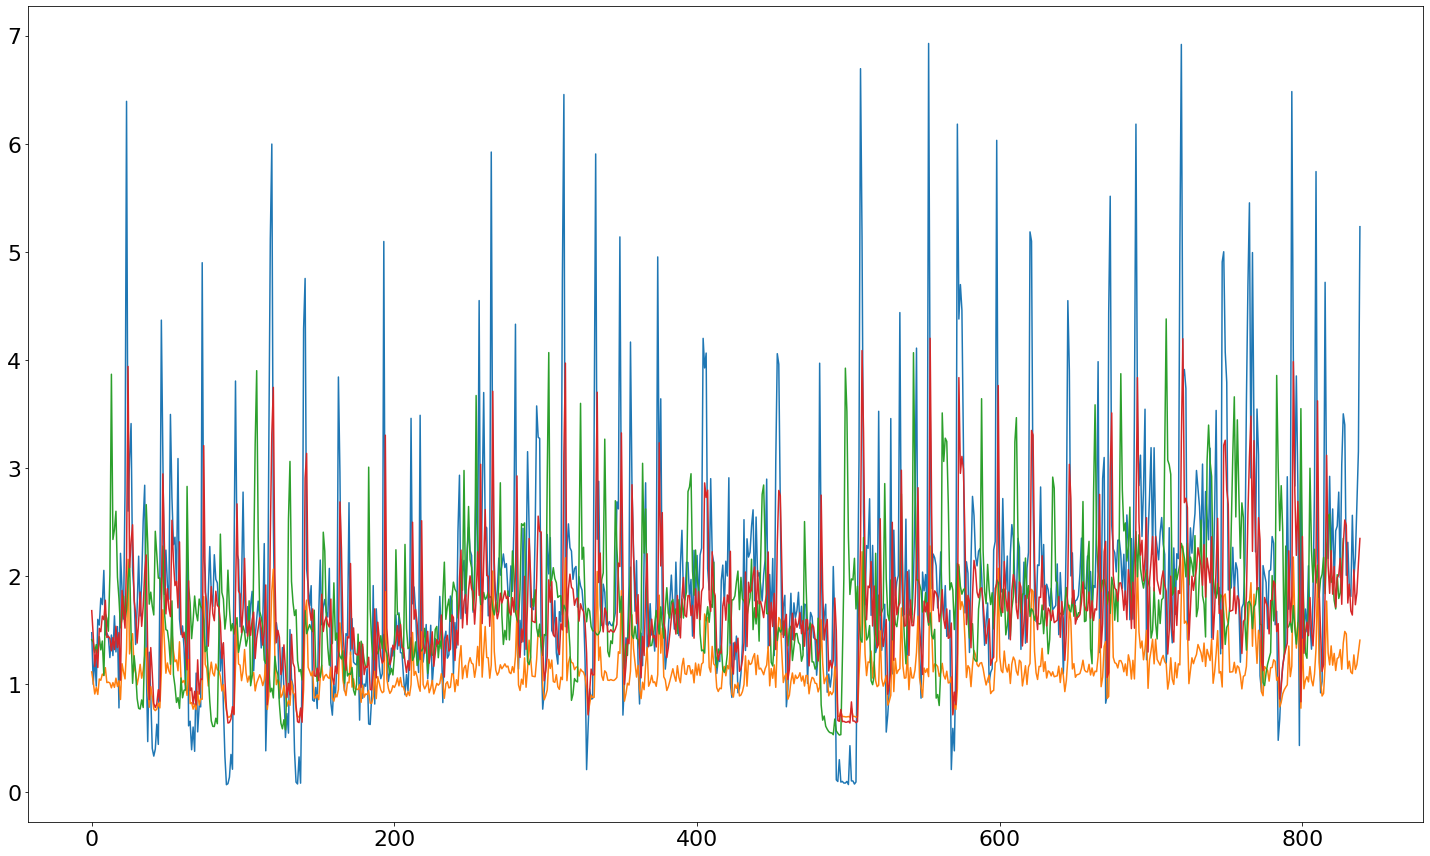

In [100]:
plt.plot(pred_test['true_apt_10'])
plt.plot(pred_test['fed_apt_10'])
plt.plot(pred_test['simple_lstm_apt_10'])
plt.plot(pred_test['convlstm_apt_10'])

In [107]:
multi_train ={}
multi_test ={}

multi_rmse_train = {}
multi_rmse_test = {}

multi_mape_train ={}
multi_mape_test = {}

In [109]:
for key, value in apartments.items():
    multi_train_pred, multi_test_pred,multi_train_true, multi_test_true,multi_error_train,multi_error_test, multi_mape1_train, multi_mape1_test = train_multi_model(value, epochs=50)
    multi_train[f"true_{key}"] = multi_train_true
    multi_train[f"multi_{key}"] = multi_train_pred

    multi_test[f"true_{key}"] = multi_test_true
    multi_test[f"multi_{key}"] = multi_test_pred

    multi_rmse_test[f"multi_{key}"] = multi_error_test
    multi_rmse_train[f"multi_{key}"] = multi_error_train

    multi_mape_train[f"multi_{key}"] = multi_mape1_train
    multi_mape_test[f"multi_{key}"] = multi_mape1_test

(7553, 1, 39) (7553,) (840, 1, 39) (840,)
Epoch 1/50
119/119 - 4s - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0561 - 4s/epoch - 34ms/step
Epoch 2/50
119/119 - 1s - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0508 - 1s/epoch - 11ms/step
Epoch 3/50
119/119 - 1s - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0491 - 1s/epoch - 10ms/step
Epoch 4/50
119/119 - 1s - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0476 - 1s/epoch - 10ms/step
Epoch 5/50
119/119 - 1s - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0466 - 1s/epoch - 11ms/step
Epoch 6/50
119/119 - 1s - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0459 - 1s/epoch - 11ms/step
Epoch 7/50
119/119 - 1s - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0454 - 1s/epoch - 11ms/step
Epoch 8/50
119/119 - 1s - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0450 - 1s/epoch - 

In [112]:
pd.DataFrame.from_dict(multi_rmse_test, orient="index").to_csv("apartments_multi.csv")

In [121]:
multi_train_pred, multi_test_pred,multi_train_true, multi_test_true,multi_error_train,multi_error_test, multi_mape1_train, multi_mape1_test = train_multi_model(apartments['home_40(t)'], epochs=50)
    
multi_train["true_house_40(t)"] = multi_train_true
multi_train["multi_house_40(t)"] = multi_train_pred

multi_test["true_house_40(t)"] = multi_test_true
multi_test["multi_house_40(t)"] = multi_test_pred

multi_rmse_test["multi_house_40(t)"] = multi_error_test
multi_rmse_train["multi_house_40(t)"] = multi_error_train

multi_mape_train["multi_house_40(t)"] = multi_mape1_train
multi_mape_test["multi_house_40(t)"] = multi_mape1_test

(7553, 1, 39) (7553,) (840, 1, 39) (840,)
Epoch 1/50
119/119 - 4s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0584 - 4s/epoch - 37ms/step
Epoch 2/50
119/119 - 1s - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0488 - 1s/epoch - 11ms/step
Epoch 3/50
119/119 - 1s - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0480 - 1s/epoch - 9ms/step
Epoch 4/50
119/119 - 1s - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0477 - 1s/epoch - 11ms/step
Epoch 5/50
119/119 - 1s - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0476 - 1s/epoch - 13ms/step
Epoch 6/50
119/119 - 1s - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0475 - 1s/epoch - 8ms/step
Epoch 7/50
119/119 - 1s - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0475 - 1s/epoch - 9ms/step
Epoch 8/50
119/119 - 1s - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0474 - 1s/epoch - 12m

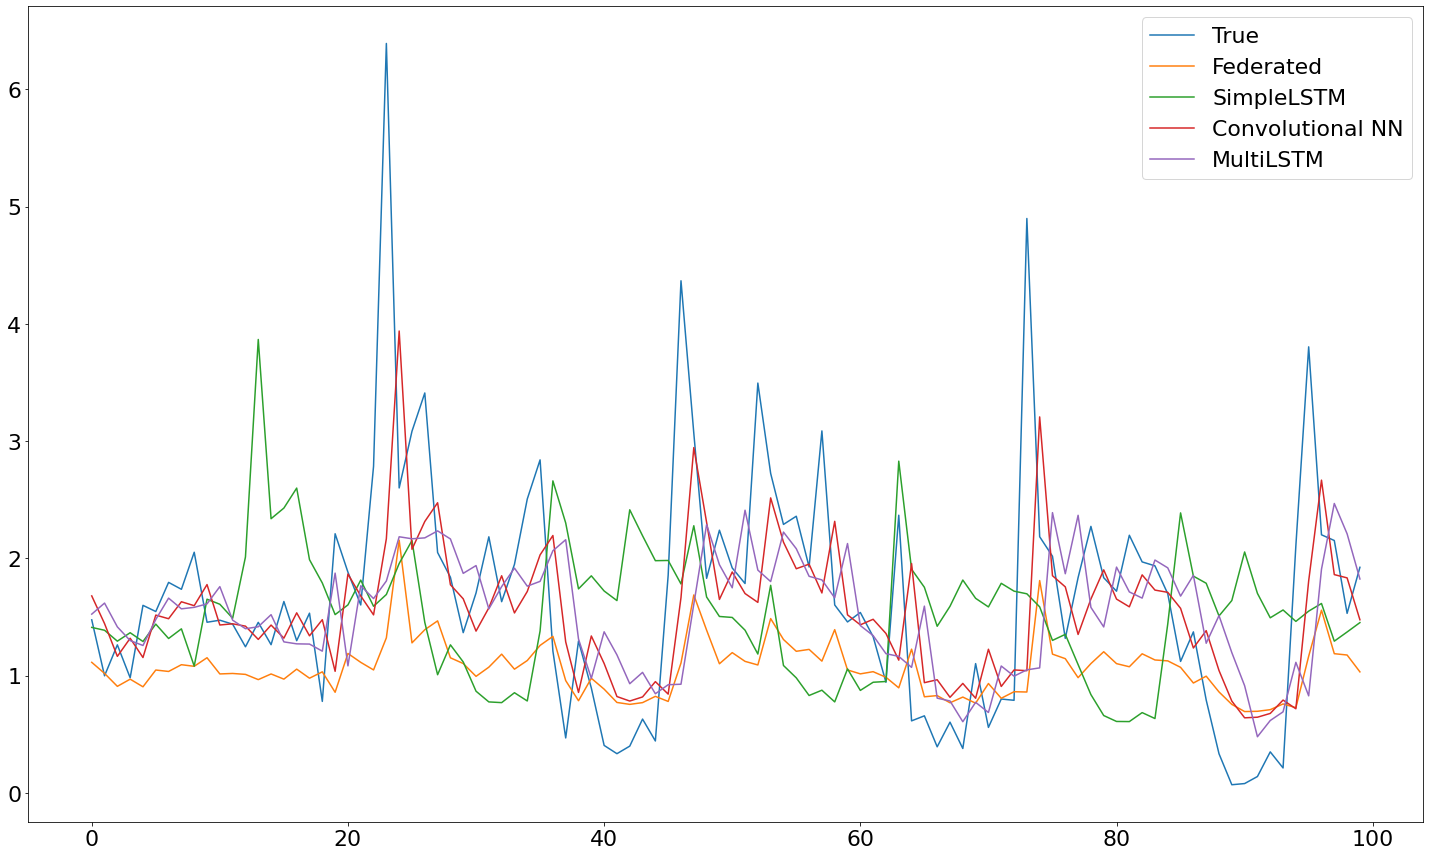

In [159]:
plt.plot(pred_test['true_apt_10'][0:100])
plt.plot(pred_test['fed_apt_10'][0:100])
plt.plot(pred_test['simple_lstm_apt_10'][0:100])
plt.plot(pred_test[f'convlstm_apt_10'][0:100])
plt.plot(multi_test['multi_home_11(t)'][0:100])


plt.legend(['True', "Federated","SimpleLSTM","Convolutional NN","MultiLSTM"])

In [138]:
predictions= pd.DataFrame.from_dict(pred_test, orient="index")

In [147]:
predictions= predictions.T

<AxesSubplot:xlabel='Time', ylabel='Load in kWh'>

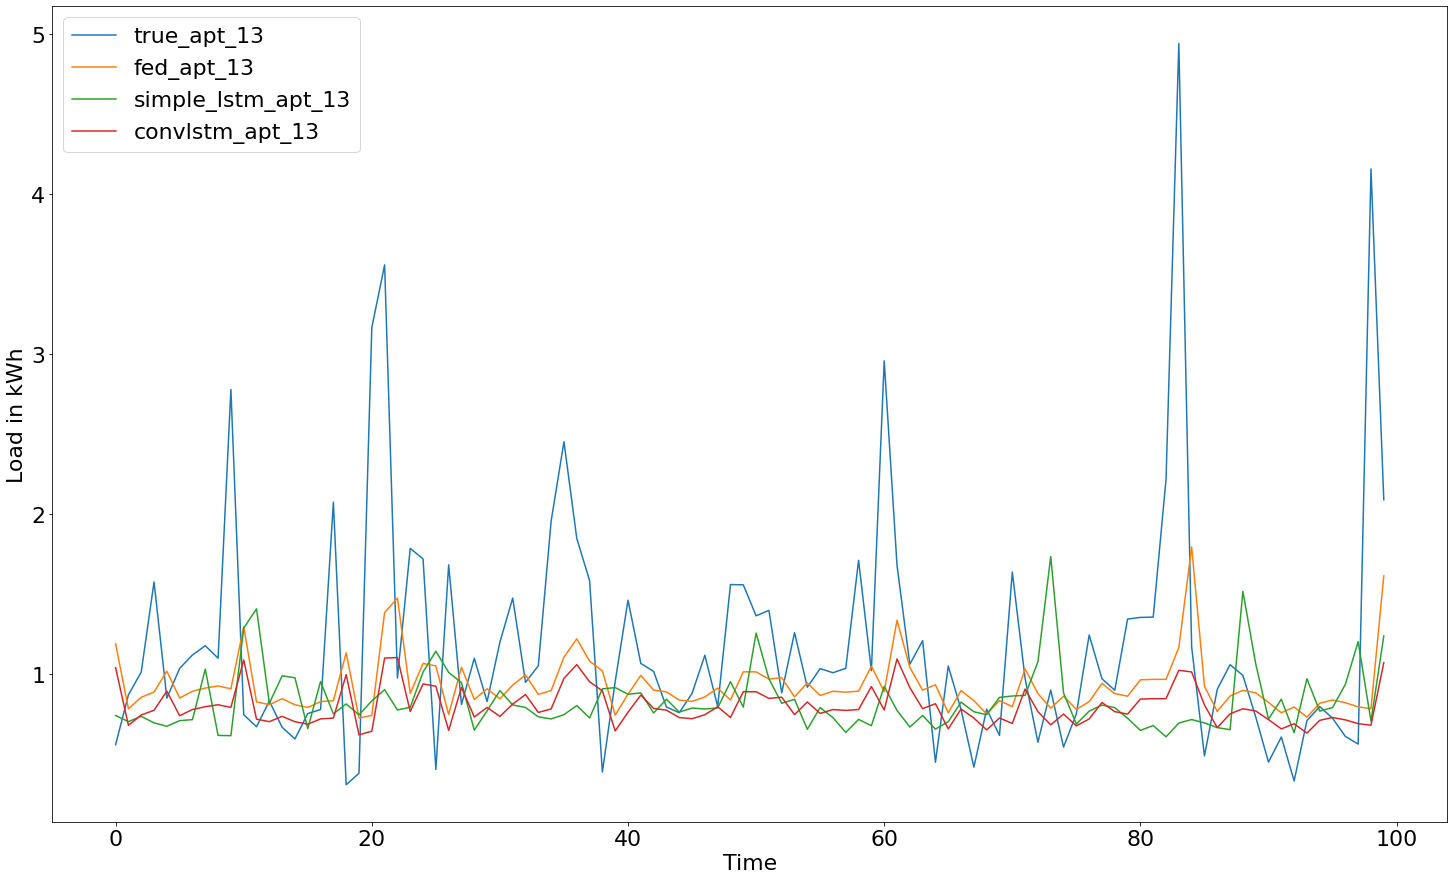

In [155]:
predictions[['true_apt_13',"fed_apt_13","simple_lstm_apt_13","convlstm_apt_13"]].iloc[0:100,:].plot(xlabel="Time", ylabel="Load in kWh")

In [163]:
pd.DataFrame.from_dict(mape_test, orient="index").to_csv("mape_apts.csv")

In [166]:
pd.DataFrame.from_dict(multi_mape_test, orient="index").to_csv("mape_multi_apts.csv")